In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
import matplotlib.pyplot as plt

# Basic Calculation

In [ ]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)
Ndriver = len(rho)
print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [ ]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

# True Distribution

100000 out-of-sample scenarios

In [ ]:
# if Path(filename_save_out+'.npz').is_file():
#     Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
# else:
# Generating Scenarios
y = np.zeros((Nout,Ndriver))
# -------- Insert your code here -------- #
 ## Define variables
w = np.zeros((Nout,K))
cs_new = np.zeros((Nout,K))
z = np.random.normal(0,1,(K,1))
Losses_out = np.zeros((Nout,K))

### Calculate losses for out-of-sample scenarios

In [ ]:
for s in range(0, Nout):
        # -------- Insert your code here -------- #
  normal_vector = np.random.normal(0, 1, (Ndriver))
  y[s,:] = np.matmul(sqrt_rho,normal_vector)
  for k in range(0,K):
    cd = driver[k]
    w[int(s),int(k)] = np.dot(beta[int(k)],y[int(s),int(cd)]) + np.dot(np.sqrt(1-beta[int(k)]**2),z[int(k)]) # Compute 2
    state = np.append(w[int(s),int(k)],CS_Bdry[int(k),:])
    state = np.sort(state)
    cs_index = np.where(state == w[int(s),int(k)]) 
    cs_new[int(s),int(k)] = cs_index[0]   # Find the new cs
    # Calculated out-of-sample losses (100000 x 100)
    # Losses_out (sparse matrix)
    Losses_out[int(s),int(k)] = exposure[int(k),cs_index]

In [ ]:
Losses_out

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Calculate VaR and CVaR for out-of-sample  scenarios
 For non-normal and normal distribution

In [ ]:
# %reset_selective -f Losses_out_port

In [ ]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))  
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix #REMOVED .toarray()

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Calculate the losses for each portfolio

Losses_out_port = np.zeros((Nout,2))
Losses_out_port[:,0] = np.sort(np.dot(Losses_out,x0[0]))
Losses_out_port[:,1] = np.sort(np.dot(Losses_out,x0[1]))
Losses_out_port = Losses_out_port.T 

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

In [ ]:
for portN in range(2):
  # Compute VaR and CVaR
  for q in range(alphas.size):
    alf = alphas[q]
    VaRout[portN, q] = Losses_out_port[portN][int(math.ceil(Nout* alf)) - 1]
    VaRinN[portN, q] = np.mean(Losses_out_port[portN]) + scs.norm.ppf(alf) * np.std(Losses_out_port[portN])
    CVaRout[portN, q] = (1 /(Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN, q] + sum(Losses_out_port[portN][int(math.ceil(Nout * alf)):]))
    CVaRinN[portN, q] = np.mean(Losses_out_port[portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(Losses_out_port[portN])

## Plot the distribution for out-of-sample scenarios

### True Distribution (Out of Sample)

#### Portfolio 1

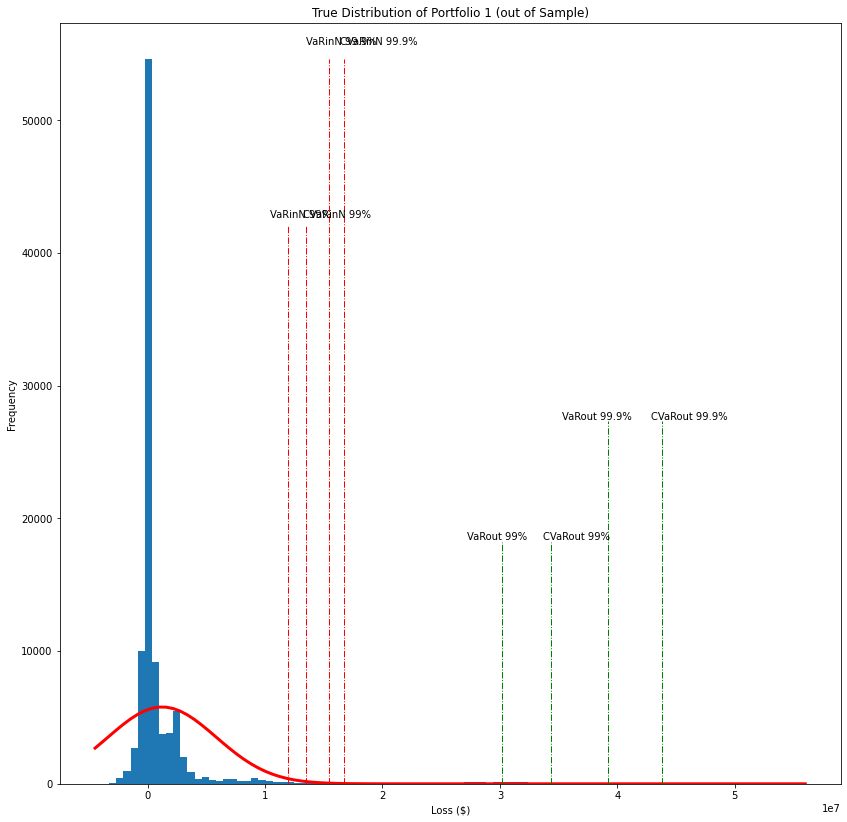

In [ ]:
# Plot out of sample non-normal and normal 
plt.figure(figsize=(14,14))

frequencyCounts, binLocations, patches = plt.hist(Losses_out_port[0], 100)
normf = (1 / (np.std(Losses_out_port[0]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_port[0])) / np.std(Losses_out_port[0])).astype("float64")** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts) /3], color='g', linewidth=1, linestyle='-.')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/3], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')

plt.text(0.90 * VaRout[0,0], max(frequencyCounts) /2.97, 'VaRout 99%')
plt.text(0.90 * VaRout[0,1], max(frequencyCounts) / 1.99, 'VaRout 99.9%')
plt.text(0.98 * CVaRout[0,0], max(frequencyCounts) / 2.97, 'CVaRout 99%')
plt.text(0.98 * CVaRout[0,1], max(frequencyCounts) / 1.99, 'CVaRout 99.9%')

plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')

plt.text(0.87 * VaRinN[0,0], max(frequencyCounts) /1.28, 'VaRinN 99%')
plt.text(0.87 * VaRinN[0,1], max(frequencyCounts) / 0.98, 'VaRinN 99.9%')
plt.text(0.98 * CVaRinN[0,0], max(frequencyCounts) / 1.28, 'CVaRinN 99%')
plt.text(0.98 * CVaRinN[0,1], max(frequencyCounts) / 0.98, 'CVaRinN 99.9%')

plt.title('True Distribution of Portfolio 1 (out of Sample)')
plt.xlabel('Loss ($)')
plt.ylabel('Frequency')
plt.draw()

#### Portfolio 2

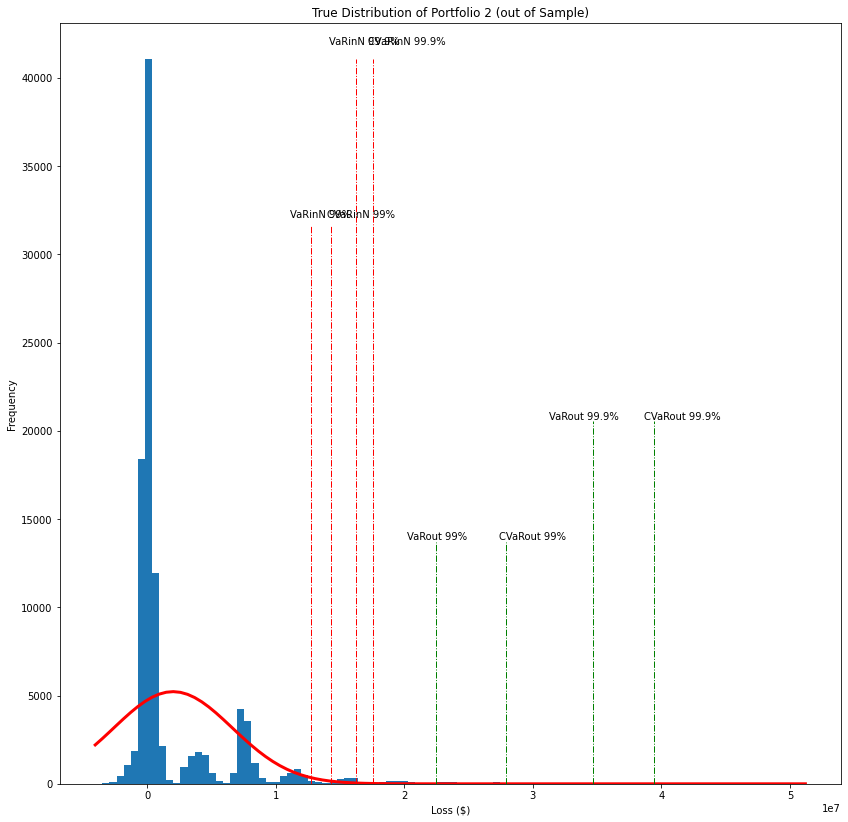

In [ ]:
# Plot out of sample non-normal and normal 

plt.figure(figsize=(14,14))

frequencyCounts, binLocations, patches = plt.hist(Losses_out_port[1], 100)
normf = (1 / (np.std(Losses_out_port[1]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_port[1])) / np.std(Losses_out_port[1])).astype("float64")** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts) /3], color='g', linewidth=1, linestyle='-.')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/3], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')

plt.text(0.90 * VaRout[1,0], max(frequencyCounts) /2.97, 'VaRout 99%')
plt.text(0.90 * VaRout[1,1], max(frequencyCounts) / 1.99, 'VaRout 99.9%')
plt.text(0.98 * CVaRout[1,0], max(frequencyCounts) / 2.97, 'CVaRout 99%')
plt.text(0.98 * CVaRout[1,1], max(frequencyCounts) / 1.99, 'CVaRout 99.9%')

plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')

plt.text(0.87 * VaRinN[1,0], max(frequencyCounts) /1.28, 'VaRinN 99%')
plt.text(0.87 * VaRinN[1,1], max(frequencyCounts) / 0.98, 'VaRinN 99.9%')
plt.text(0.98 * CVaRinN[1,0], max(frequencyCounts) / 1.28, 'CVaRinN 99%')
plt.text(0.98 * CVaRinN[1,1], max(frequencyCounts) / 0.98, 'CVaRinN 99.9%')

plt.title('True Distribution of Portfolio 2 (out of Sample)')
plt.xlabel('Loss ($)')
plt.ylabel('Frequency')
plt.draw()

In [ ]:
# Calculate the difference between Normal Distribution and True Distribution for out of sample scenarios

model_error = np.zeros((2,2))
for i in range(2):
  for j in range(2):
    model_error[i,j] = VaRout[i,j] - VaRinN[i,j]

print("For Out of Sample")
print("For portfolio 1, model error at 99% is ($Loss) : " + str(model_error[0,0]))
print("For portfolio 1, model error at 99.9% is ($Loss) : " + str(model_error[0,1]))
print("For portfolio 2, model error at 99% is ($Loss) : " + str(model_error[1,0]))
print("For portfolio 2, model error at 99% is ($Loss) : " + str(model_error[1,1]))

For Out of Sample
For portfolio 1, model error at 99% is ($Loss) : 18236891.061340407
For portfolio 1, model error at 99.9% is ($Loss) : 23747630.77650666
For portfolio 2, model error at 99% is ($Loss) : 9698772.093220916
For portfolio 2, model error at 99% is ($Loss) : 18443608.269567613


# Monte Carlo Approximation 1 
5000 insample scenarios (1000 systematic and 5 idiosyncratic scenarios)

In [ ]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
  for q in range(alphas.size):
    VaRinMC1[portN, q] = np.zeros(N_trials)
    VaRinMC2[portN, q] = np.zeros(N_trials)
    VaRinN1[portN, q] = np.zeros(N_trials)
    VaRinN2[portN, q] = np.zeros(N_trials)
    CVaRinMC1[portN, q] = np.zeros(N_trials)
    CVaRinMC2[portN, q] = np.zeros(N_trials)
    CVaRinN1[portN, q] = np.zeros(N_trials)
    CVaRinN2[portN, q] = np.zeros(N_trials)

### DEFINE ##### 
y_inMC1 = np.zeros((Nout,Ndriver))
z_inMC1 = np.zeros((1))  ## For simplicity and faster computation time
w_inMC1 = np.zeros((K,1))
cs_newMC1 = np.zeros((K))
Losses_inMC1 = np.zeros((Nin,K))

### DEFINE #### 
y_inMC2 = np.zeros((Nin,Ndriver))
w_ = np.zeros((Nin,K))
cs_newMC2 = np.zeros((Nin,K))
z_inMC2 = np.random.normal(0,1,(K,1))
w_inMC2 = np.zeros((Nin,K))
Losses_inMC2 = np.zeros((Nin,K))

for tr in range(0, N_trials):
    # Monte Carlo approximation 1

  for s in range(0, np.int(np.ceil(Nin / Ns))): # systemic scenarios
    normal_vector = np.random.normal(0,1,(Ndriver))
    y_inMC1 = np.dot(sqrt_rho,normal_vector)
    for si in range(0, Ns): # idiosyncratic scenarios for each systemic
      for k in range(0,K):
        z_inMC1 = np.random.normal(0,1)
        cd = driver[k]
        w_inMC1[int(k)] = np.dot(beta[int(k)],y_inMC1[int(cd)]) + np.dot(np.sqrt(1-beta[int(k)]**2),z_inMC1) # Calcuate w
        stateMC1 = np.append(CS_Bdry[int(k),:],w_inMC1[int(k)])
        stateMC1 = np.sort(stateMC1)
        cs_indexMC1 = np.where(stateMC1 == w_inMC1[int(k)])
        cs_newMC1[int(k)] = cs_index[0]     # Find new cs
        # Calculate losses for MC1 approximation (5000 x 100)
        # Losses_inMC1
        Losses_inMC1[Ns*int((s)-1)+si,int(k)] = exposure[int(k),cs_indexMC1]

          # for k in range(0,K):
          #   cd = driver[k]
          #   w_inMC1[int(s),int(si),int(k)] = np.dot(beta[int(k)],y_inMC1[int(s),int(cd)]) + np.dot(np.sqrt(1-beta[int(k)]**2),z_inMC1[int(s),int(si),int(k)])
          #   state = np.append(w[int(s),int(si),int(k)],CS_Bdry[int(k),:])
          #   state = np.sort(state)
          #   cs_index = np.where(state == w[int(s),int(si),int(k)])
          #   cs_new[int(s),int(k)] = cs_index[0]
          #   Losses_inMC1[int(s),int(si),int(k)] = exposure[int(k),cs_index]

In [ ]:
Losses_inMC1

array([[     0.,      0.,      0., ...,      0.,  16976., 154023.],
       [ 11484.,      0.,      0., ...,      0.,      0.,      0.],
       [ 11484.,      0.,      0., ...,      0.,      0.,  56464.],
       ...,
       [     0.,      0.,      0., ...,      0.,      0.,      0.],
       [     0.,      0., -22345., ...,      0.,      0.,  56464.],
       [     0.,      0.,      0., ...,      0.,      0., -18827.]])

# Monte Carlo Approximation 2 
5000 in-sample scenarios (5000 systematic and 1 idiosyncratic scenarios)





In [ ]:
#  Monte Carlo approximation 2
for tr in range(0, N_trials):
  for s in range(0, Nin): # systemic scenarios (1 idiosyncratic scenario for each systemic)
    normal_vector = np.random.normal(0, 1, (Ndriver))
    y_inMC2[s,:] = np.matmul(sqrt_rho,normal_vector)
    for k in range(0,K):
      cd = driver[k]
      w_inMC2[int(s),int(k)] = np.dot(beta[int(k)],y_inMC2[int(s),int(cd)]) + np.dot(np.sqrt(1-beta[int(k)]**2),z_inMC2[int(k)]) # Compute w
      stateMC2 = np.append(w_inMC2[int(s),int(k)],CS_Bdry[int(k),:])
      stateMC2 = np.sort(stateMC2)
      cs_indexMC2 = np.where(stateMC2 == w_inMC2[int(s),int(k)]) # Find new cs
      cs_newMC2[int(s),int(k)] = cs_indexMC2[0]
    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
      Losses_inMC2[int(s),int(k)] = exposure[int(k),cs_indexMC2]

In [ ]:
Losses_inMC2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Compute VaR and CVaR for Monte Carlo Approximations 1 and 2

In [ ]:
# %reset_selective -f portfolio_loss_MC2

In [ ]:
portf_loss_inMC1 = np.zeros((2,Nin))
portf_loss_inMC2 = np.zeros((2,Nin))
mu_p_MC1 = np.zeros((2))
sigma_p_MC1 = np.zeros((2))
mu_p_MC2 = np.zeros((2))
sigma_p_MC2 = np.zeros((2))

for tr in range(0, N_trials):
  for portN in range(2):
    for q in range(alphas.size):
      alf = alphas[q]
      # Compute portfolio loss
      portf_loss_inMC1[portN] = np.sort(np.dot(Losses_inMC1,x0[int(portN)])) # Loss portfolio 1
      portf_loss_inMC2[portN] = np.sort(np.dot(Losses_inMC2,x0[int(portN)])) # Loss portfolio 2
      mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
      var_MC1 = np.cov(Losses_inMC1, rowvar=False)  # .toarray()
      mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
      var_MC2 = np.cov(Losses_inMC2, rowvar=False) # .toarray()
      # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
      # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
      # Compute VaR and CVaR for the current trial
      mu_p_MC1[int(portN)] = np.dot(mu_MC1,x0[int(portN)])
      sigma_p_MC1[portN] = np.std(portf_loss_inMC1)
      mu_p_MC2[portN] = np.dot(mu_MC2,x0[portN])
      sigma_p_MC2[portN] = np.std(portf_loss_inMC2)
      VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[portN][int(math.ceil(Nin* alf)) - 1]
      VaRinN1[portN, q][tr - 1] =  mu_p_MC1[portN] + scs.norm.ppf(alf) * sigma_p_MC1[portN]
      CVaRinMC1[portN, q][tr - 1] = (1 /(Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC1[portN, q][tr-1] + sum(Losses_inMC1[portN][int(math.ceil(Nin * alf)):]))
      CVaRinN1[portN, q][tr - 1] =  mu_p_MC1[portN] + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC1[portN]
      VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[portN][int(math.ceil(Nin* alf)) - 1]
      VaRinN2[portN, q][tr - 1] =  mu_p_MC2[portN] + scs.norm.ppf(alf) * sigma_p_MC2[portN]
      CVaRinMC2[portN, q][tr - 1] = (1 /(Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC2[portN, q][tr-1] + sum(Losses_inMC2[portN][int(math.ceil(Nin * alf)):]))
      CVaRinN2[portN, q][tr - 1] =  mu_p_MC2[portN] + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC2[portN]

## Plot the distribution for Monte Carlo Approximations

### Distribution for Monte Carlo 1

#### MC1 - Portfolio 1

Text(0, 0.5, 'Frequency')

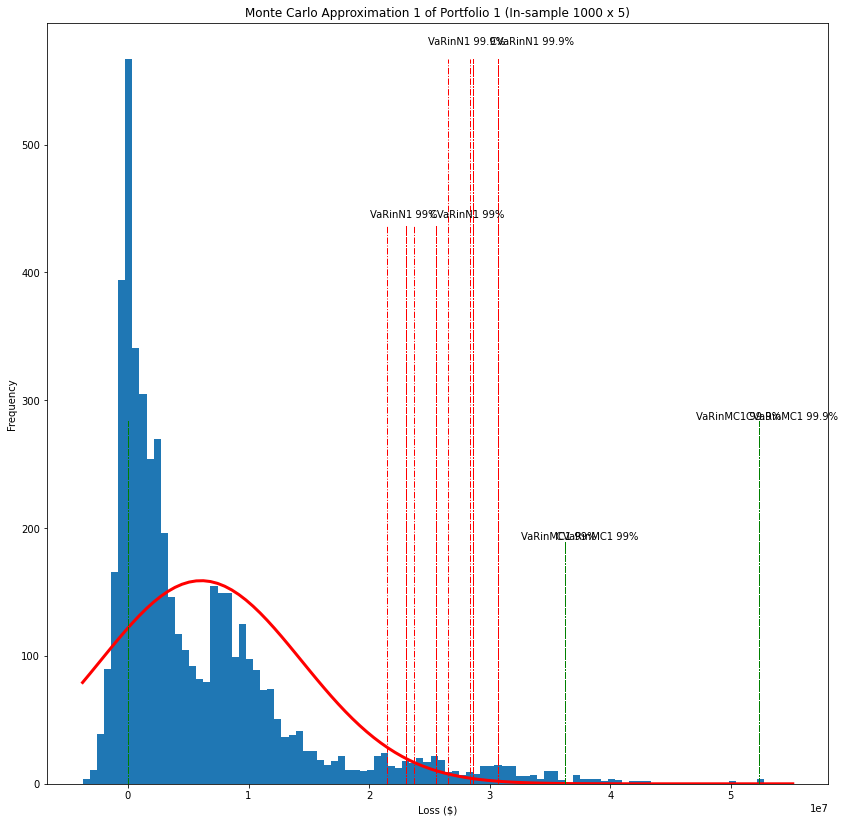

In [ ]:
# Plot MC1 non-normal and normal 

plt.figure(figsize=(14,14))

frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC1[0], 100)
normf = (1 / (np.std(portf_loss_inMC1[0]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_inMC1[0])) / np.std(portf_loss_inMC1[0])).astype("float64")** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.plot([VaRinMC1[0,0], VaRinMC1[0,0]], [0, max(frequencyCounts) /3], color='g', linewidth=1, linestyle='-.')
plt.plot([VaRinMC1[0,1], VaRinMC1[0,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC1[0,0], CVaRinMC1[0,0]], [0, max(frequencyCounts)/3], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC1[0,1], CVaRinMC1[0,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')

plt.text(0.90 * np.mean(VaRinMC1[0,0]), max(frequencyCounts) /2.97, 'VaRinMC1 99%')
plt.text(0.90 * np.mean(VaRinMC1[0,1]), max(frequencyCounts) / 1.99, 'VaRinMC1 99.9%')
plt.text(0.98 * np.mean(VaRinMC1[0,0]), max(frequencyCounts) / 2.97, 'CVaRinMC1 99%')
plt.text(0.98 * np.mean(VaRinMC1[0,1]), max(frequencyCounts) / 1.99, 'CVaRinMC1 99.9%')

plt.plot([VaRinN1[0,0], VaRinN1[0,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN1[0,1], VaRinN1[0,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN1[0,0], CVaRinN1[0,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN1[0,1], CVaRinN1[0,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')

plt.text(0.87 * np.mean(VaRinN1[0,0]), max(frequencyCounts) /1.28, 'VaRinN1 99%')
plt.text(0.87 * np.mean(VaRinN1[0,1]), max(frequencyCounts) / 0.98, 'VaRinN1 99.9%')
plt.text(0.98 * np.mean(CVaRinN1[0,0]), max(frequencyCounts) / 1.28, 'CVaRinN1 99%')
plt.text(0.98 * np.mean(CVaRinN1[0,1]), max(frequencyCounts) / 0.98, 'CVaRinN1 99.9%')

plt.title('Monte Carlo Approximation 1 of Portfolio 1 (In-sample 1000 x 5)')
plt.xlabel('Loss ($)')
plt.ylabel('Frequency')
# plt.draw()

#### MC 1 - Portfolio 2

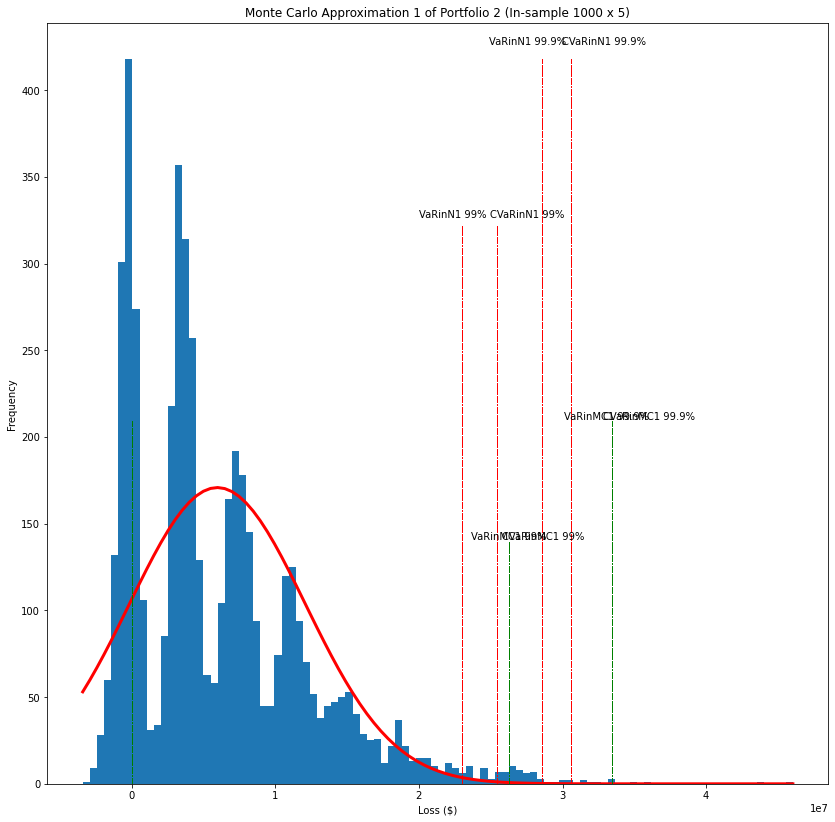

In [ ]:
# Plot MC1 non-normal and normal

plt.figure(figsize=(14,14))

frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC1[1], 100)
normf = (1 / (np.std(portf_loss_inMC1[1]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_inMC1[1])) / np.std(portf_loss_inMC1[1])).astype("float64")** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.plot([VaRinMC1[1,0], VaRinMC1[1,0]], [0, max(frequencyCounts) /3], color='g', linewidth=1, linestyle='-.')
plt.plot([VaRinMC1[1,1], VaRinMC1[1,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC1[1,0], CVaRinMC1[1,0]], [0, max(frequencyCounts)/3], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC1[1,1], CVaRinMC1[1,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')

plt.text(0.90 * np.mean(VaRinMC1[1,0]), max(frequencyCounts) /2.97, 'VaRinMC1 99%')
plt.text(0.90 * np.mean(VaRinMC1[1,1]), max(frequencyCounts) / 1.99, 'VaRinMC1 99.9%')
plt.text(0.98 * np.mean(VaRinMC1[1,0]), max(frequencyCounts) / 2.97, 'CVaRinMC1 99%')
plt.text(0.98 * np.mean(VaRinMC1[1,1]), max(frequencyCounts) / 1.99, 'CVaRinMC1 99.9%')

plt.plot([VaRinN1[1,0], VaRinN1[1,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN1[1,1], VaRinN1[1,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN1[1,0], CVaRinN1[1,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN1[1,1], CVaRinN1[1,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')

plt.text(0.87 * np.mean(VaRinN1[1,0]), max(frequencyCounts) /1.28, 'VaRinN1 99%')
plt.text(0.87 * np.mean(VaRinN1[1,1]), max(frequencyCounts) / 0.98, 'VaRinN1 99.9%')
plt.text(0.98 * np.mean(CVaRinN1[1,0]), max(frequencyCounts) / 1.28, 'CVaRinN1 99%')
plt.text(0.98 * np.mean(CVaRinN1[1,1]), max(frequencyCounts) / 0.98, 'CVaRinN1 99.9%')

plt.title('Monte Carlo Approximation 1 of Portfolio 2 (In-sample 1000 x 5)')
plt.xlabel('Loss ($)')
plt.ylabel('Frequency')
plt.draw()

### Distribution for Monte Carlo 2

#### MC 2 - Portfolio 1

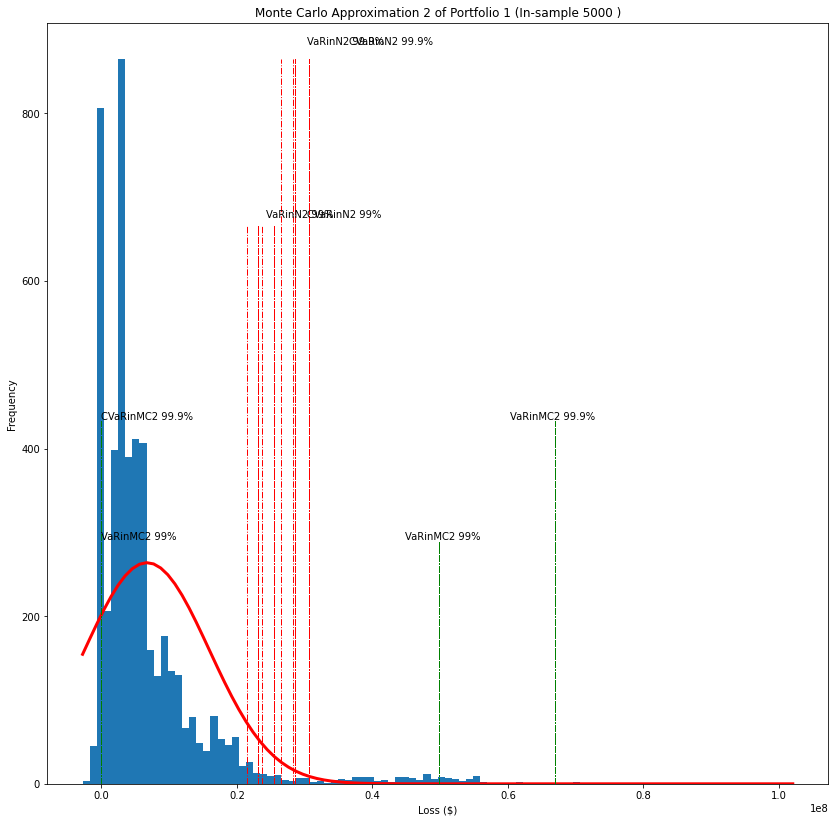

In [ ]:
# Plot MC2 non-normal and normal

plt.figure(figsize=(14,14))

frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC2[0], 100)
normf = (1 / (np.std(portf_loss_inMC2[0]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_inMC2[0])) / np.std(portf_loss_inMC2[0])).astype("float64")** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.plot([VaRinMC2[0,0], VaRinMC2[0,0]], [0, max(frequencyCounts) /3], color='g', linewidth=1, linestyle='-.')
plt.plot([VaRinMC2[0,1], VaRinMC2[0,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC2[0,0], CVaRinMC2[0,0]], [0, max(frequencyCounts)/3], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC2[0,1], CVaRinMC2[0,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')

plt.text(0.90 * np.mean(VaRinMC2[0,0]), max(frequencyCounts) /2.97, 'VaRinMC2 99%')
plt.text(0.90 * np.mean(VaRinMC2[0,1]), max(frequencyCounts) / 1.99, 'VaRinMC2 99.9%')
plt.text(0.98 * np.mean(CVaRinMC2[0,0]), max(frequencyCounts) / 2.97, 'VaRinMC2 99%')
plt.text(0.98 * np.mean(CVaRinMC2[0,1]), max(frequencyCounts) / 1.99, 'CVaRinMC2 99.9%')

plt.plot([VaRinN1[0,0], VaRinN1[0,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN1[0,1], VaRinN1[0,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN1[0,0], CVaRinN1[0,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN1[0,1], CVaRinN1[0,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')

plt.text(0.87 * np.mean(VaRinN2[0,0]), max(frequencyCounts) /1.28, 'VaRinN2 99%')
plt.text(0.87 * np.mean(VaRinN2[0,1]), max(frequencyCounts) / 0.98, 'VaRinN2 99.9%')
plt.text(0.98 * np.mean(CVaRinN2[0,0]), max(frequencyCounts) / 1.28, 'CVaRinN2 99%')
plt.text(0.98 * np.mean(CVaRinN2[0,1]), max(frequencyCounts) / 0.98, 'CVaRinN2 99.9%')

plt.title('Monte Carlo Approximation 2 of Portfolio 1 (In-sample 5000 )')
plt.xlabel('Loss ($)')
plt.ylabel('Frequency')
plt.draw()

#### MC 2 - Portfolio 2

ERROR! Session/line number was not unique in database. History logging moved to new session 60


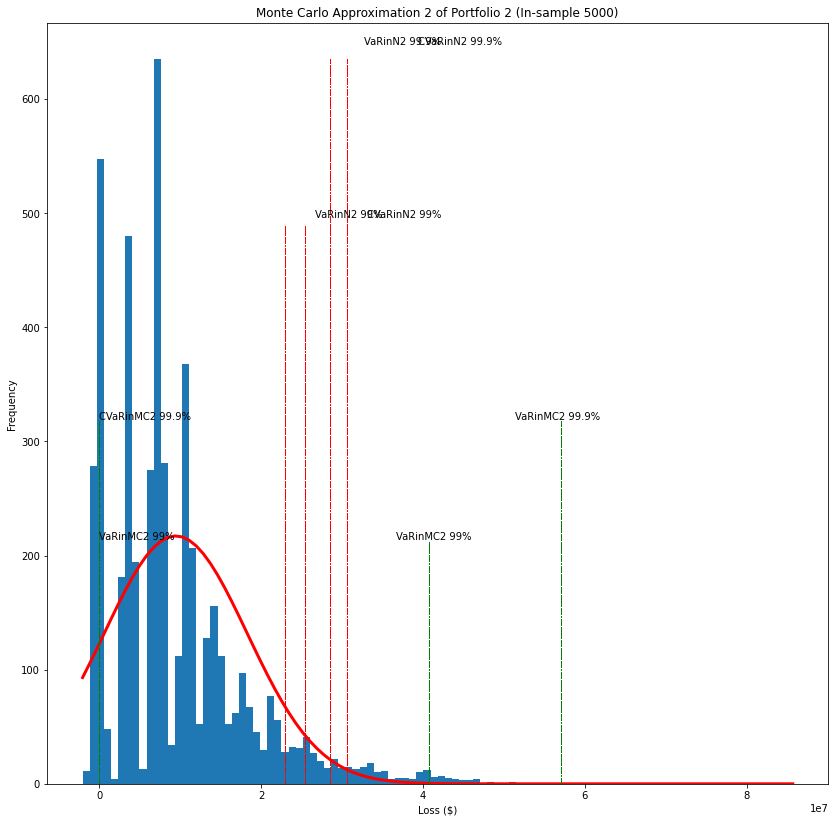

In [ ]:
# Plot MC2 non-normal and normal
plt.figure(figsize=(14,14))

frequencyCounts, binLocations, patches = plt.hist(portf_loss_inMC2[1], 100)
normf = (1 / (np.std(portf_loss_inMC2[1]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_inMC2[1])) / np.std(portf_loss_inMC2[1])).astype("float64")** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.plot([VaRinMC2[1,0], VaRinMC2[1,0]], [0, max(frequencyCounts) /3], color='g', linewidth=1, linestyle='-.')
plt.plot([VaRinMC2[1,1], VaRinMC2[1,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC2[1,0], CVaRinMC2[1,0]], [0, max(frequencyCounts)/3], color='g', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC2[1,1], CVaRinMC2[1,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')

plt.text(0.90 * np.mean(VaRinMC2[1,0]), max(frequencyCounts) /2.97, 'VaRinMC2 99%')
plt.text(0.90 * np.mean(VaRinMC2[1,1]), max(frequencyCounts) / 1.99, 'VaRinMC2 99.9%')
plt.text(0.98 * np.mean(CVaRinMC2[1,0]), max(frequencyCounts) / 2.97, 'VaRinMC2 99%')
plt.text(0.98 * np.mean(CVaRinMC2[1,1]), max(frequencyCounts) / 1.99, 'CVaRinMC2 99.9%')

plt.plot([VaRinN1[1,0], VaRinN1[1,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN1[1,1], VaRinN1[1,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN1[1,0], CVaRinN1[1,0]], [0, max(frequencyCounts)/1.3], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN1[1,1], CVaRinN1[1,1]], [0, max(frequencyCounts)/1], color='r', linewidth=1, linestyle='-.')

plt.text(0.87 * np.mean(VaRinN2[1,0]), max(frequencyCounts) /1.28, 'VaRinN2 99%')
plt.text(0.87 * np.mean(VaRinN2[1,1]), max(frequencyCounts) / 0.98, 'VaRinN2 99.9%')
plt.text(0.98 * np.mean(CVaRinN2[1,0]), max(frequencyCounts) / 1.28, 'CVaRinN2 99%')
plt.text(0.98 * np.mean(CVaRinN2[1,1]), max(frequencyCounts) / 0.98, 'CVaRinN2 99.9%')

plt.title('Monte Carlo Approximation 2 of Portfolio 2 (In-sample 5000)')
plt.xlabel('Loss ($)')
plt.ylabel('Frequency')
plt.draw()

In [ ]:
# Sample Error for Monte Carlo 1

samp_errorMC1 = np.zeros((2,2))
for i in range(2):
  for j in range(2):
    samp_errorMC1[i,j] = np.mean(VaRinMC1[i,j]) - np.mean(VaRinN1[i,j])

print("For Monte Carlo 1")
print("For portfolio 1, sample error for MC1 at 99% is ($Loss) : " + str(samp_errorMC1[0,0]))
print("For portfolio 1, sample error for MC1 at 99.9% is ($Loss) : " + str(samp_errorMC1[0,1]))
print("For portfolio 2, sample error for MC1 at 99% is ($Loss) : " + str(samp_errorMC1[1,0]))
print("For portfolio 2, sample error for MC1 at 99% is ($Loss) : " + str(samp_errorMC1[1,1]))

For Monte Carlo 1
For portfolio 1, sample error for MC1 at 99% is ($Loss) : 13181989.64333018
For portfolio 1, sample error for MC1 at 99.9% is ($Loss) : 23695067.18104765
For portfolio 2, sample error for MC1 at 99% is ($Loss) : 3309266.492657244
For portfolio 2, sample error for MC1 at 99% is ($Loss) : 4890990.665749349


In [ ]:
# Sample Error for Monte Carlo 2

samp_errorMC2 = np.zeros((2,2))
for i in range(2):
  for j in range(2):
    samp_errorMC2[i,j] = np.mean(VaRinMC2[i,j]) - np.mean(VaRinN2[i,j])

print("For Monte Carlo 1")
print("For portfolio 1, sample error for MC2 at 99% is ($Loss) : " + str(samp_errorMC2[0,0]))
print("For portfolio 1, sample error for MC2 at 99.9% is ($Loss) : " + str(samp_errorMC2[0,1]))
print("For portfolio 2, sample error for MC2 at 99% is ($Loss) : " + str(samp_errorMC2[1,0]))
print("For portfolio 2, sample error for MC2 at 99% is ($Loss) : " + str(samp_errorMC2[1,1]))

For Monte Carlo 2
For portfolio 1, sample error for MC2 at 99% is ($Loss) : 21951298.240193833
For portfolio 1, sample error for MC2 at 99.9% is ($Loss) : 32149492.29244402
For portfolio 2, sample error for MC2 at 99% is ($Loss) : 10121946.226115398
For portfolio 2, sample error for MC2 at 99% is ($Loss) : 19476967.305107668


# Results of all 6 Scenarios
Non-Normal with N=1000 x 5, 5000, 100000 and <br>
Normal with mean/standard deviation computed from from N=1000 x 5, 5000, 100000



In [ ]:
# Display VaR and CVaR
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $30198919.34, CVaR 99.0% = $34327419.41
In-sample MC1: VaR 99.0% = $36233942.20, CVaR 99.0% = $  0.00
In-sample MC2: VaR 99.0% = $49851144.72, CVaR 99.0% = $  0.00
In-sample No: VaR 99.0% = $11962028.28, CVaR 99.0% = $13523701.20
In-sample N1: VaR 99.0% = $23051952.56, CVaR 99.0% = $25526840.12
In-sample N2: VaR 99.0% = $27899846.48, CVaR 99.0% = $30982595.34

Out-of-sample: VaR 99.9% = $39230037.06, CVaR 99.9% = $43773360.87
In-sample MC1: VaR 99.9% = $52325998.30, CVaR 99.9% = $  0.00
In-sample MC2: VaR 99.9% = $66998579.64, CVaR 99.9% = $  0.00
In-sample No: VaR 99.9% = $15482406.28, CVaR 99.9% = $16758311.34
In-sample N1: VaR 99.9% = $28630931.12, CVaR 99.9% = $30652943.22
In-sample N2: VaR 99.9% = $34849087.35, CVaR 99.9% = $37367729.25


Portfolio 2:

Out-of-sample: VaR 99.0% = $22437851.10, CVaR 99.0% = $27899327.81
In-sample MC1: VaR 99.0% = $26289385.91, CVaR 99.0% = $  0.00
In-sample MC2: VaR 99.0% = $40761225.91, CVaR 99.0% = $  0.00